In [1]:
import pandas as pd
import numpy as np
import arcpy
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter

In [2]:
source_df = pd.read_csv('../derived_data/150 - Board of Supervisors, District 5.txt')
source_df.head()

,precinctname,reportingtype,precinctid,precincts,registration,ballots_cast,turnout_percent,dean_preston,london_breed,writein,under_vote,over_vote
0,Pct 7501,Election Day,7501,1,574,201,35.02,54,109,1,32,0
1,Pct 7501,VBM,7501,1,574,321,55.92,89,157,1,55,0
2,Pct 7502,Election Day,7502,1,808,240,29.70,94,92,1,49,0
3,Pct 7502,VBM,7502,1,808,454,56.19,148,233,3,53,2
4,Pct 7503,Election Day,7503,1,808,252,31.19,110,89,0,44,1


In [3]:
d5_df = source_df.groupby('precinctid').agg({
        'registration': 'min',
        'ballots_cast': 'sum',
        'dean_preston': 'sum',
        'london_breed': 'sum',
        'writein': 'sum',
        'under_vote': 'sum',
        'over_vote': 'sum'
    })
d5_df['dean_percent_sup_votes'] = d5_df['dean_preston'] / (d5_df['dean_preston'] + d5_df['london_breed'] + d5_df['writein'])
d5_df['dean_percent_ballots'] = d5_df['dean_preston'] / d5_df['ballots_cast']

(array([ 1.,  0.,  0.,  0.,  1.,  2.,  1.,  3.,  4.,  6.,  5.,  4.,  9.,
         9.,  4.,  8.,  4.,  3.,  1.,  2.]),
 array([ 0.26572008,  0.2824092 ,  0.29909832,  0.31578744,  0.33247656,
         0.34916568,  0.3658548 ,  0.38254392,  0.39923304,  0.41592216,
         0.43261128,  0.4493004 ,  0.46598952,  0.48267865,  0.49936777,
         0.51605689,  0.53274601,  0.54943513,  0.56612425,  0.58281337,
         0.59950249]),
 <a list of 20 Patch objects>)

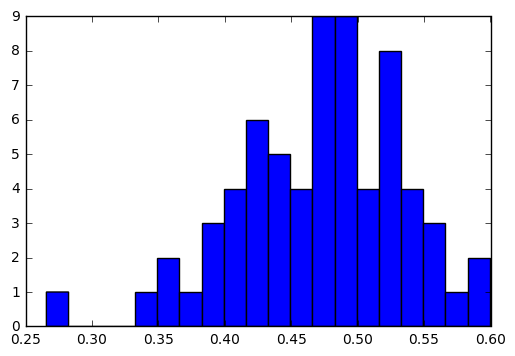

In [4]:
plt.hist(d5_df['dean_percent_sup_votes'], bins=20)

In [5]:
from scipy.stats import shapiro
shapiro(d5_df['dean_percent_sup_votes'])

(0.9826851487159729, 0.47561129927635193)

In [6]:
# That p value's way high, so we can assume normality.
print(np.mean(d5_df['dean_percent_sup_votes']))
print(np.std(d5_df['dean_percent_sup_votes']))

0.470975042118
0.0628676024744


### Let's see what other measure Dean's vote proportion best correlates with..

In [7]:
import os
from scipy.stats import linregress
vote_files = [x for x in os.listdir('../derived_data') if x[3:6] == ' - ']
results_dict = {}
excluded = []
for f in vote_files:
    df = pd.read_csv('../derived_data/{}'.format(f))
    metric_name = df.columns[7]  # The first 6 columns are uniform across all tables
    grouped = df.groupby('precinctid').agg('sum')
    grouped['metric_percent_ballots'] = grouped[metric_name] / grouped['ballots_cast']
    merged = d5_df.merge(grouped, left_index=True, right_index=True)
    if merged.empty:
        excluded.append(f)
        continue
    # Filter to only D5
    merged = merged[~merged['dean_percent_ballots'].isnull()]
    slope, intercept, r_value, p_value, std_err = linregress(merged['metric_percent_ballots'].values,
                                                             merged['dean_percent_ballots'].values)
    results_dict[f] = {
        'metric_name': metric_name,
        'slope': slope,
        'intercept': intercept,
        'rsquared': r_value**2,
        'dataframe': merged
    }

num_props = 5
fig, axs = plt.subplots(num_props,1, figsize=(5,15))
counter = 0
for name, metadata in sorted(results_dict.items(), key=lambda x: x[1]['rsquared'], reverse=True)[1:num_props+1]:
    ax = axs[counter]
    x = metadata['dataframe']['metric_percent_ballots'].values
    y = metadata['dataframe']['dean_percent_ballots'].values
    ax.scatter(x, y)
    ax.plot(x, x*metadata['slope'] + metadata['intercept'])
    ax.set_title(name[:-4])
    ax.set_ylabel('% Vote for Dean')
    ax.set_xlabel('% Vote {}'.format(metadata['metric_name'].title()))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    annotation = '''m={}\nb={}\nr^2={}'''.format(metadata['slope'], metadata['intercept'], metadata['rsquared'])
    ax.annotate(annotation, xy=(1.05, .8), xycoords='axes fraction')
    counter += 1
fig.tight_layout()

Lol, so how you voted on mandatory condoms in porn was the strongest predictor of if you would vote for dean...

In [9]:
measures_dict['240 - State Proposition 60.txt'].sort_values('metric_percent_ballots', ascending=False)

NameError: name 'measures_dict' is not defined